# Module 4 Project - Image Classification of Dog Breeds

The goal of this project is to construct a deep neural network that takes in images of various dogs and predict the breeds. To construct this model, I will use the Stanford Dog Dataset from Stanford Vision Lab. 

My approach for this project is to follow the OSEMN framework. The steps of this framework is as follow - 

1. Obtain the data
2. Scrub the data
3. Explore the data
4. Model the data
5. Interpret the data

As the first step, I will import the necessary packages to construct the model.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import xml.etree.ElementTree as ET
import cv2
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras import callbacks 
from IPython.display import SVG

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Concatenate, Lambda
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils.vis_utils import model_to_dot

# Obtaining Data

The original Stanford Dog Dataset contains 20580 images of 120 dog breeds. Since classifying 120 breeds would be overwhelming for my GPU, I would only use 25 breeds.


In [2]:
# Assigning directory paths as variables
path = r"C:\Users\13474\Desktop\Data_Science\Module 4 - Final Project\test\images\Images/"
img_dir = r"C:\Users\13474\Desktop\Data_Science\Module 4 - Final Project\test\images\Images/{}/"

# Creating a list of breeds
breed_list = os.listdir(path)

# Viewing the breed list
breed_list[:5]

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu']

# Scrubbing Data - Cleaning Labels

The breed names contain numerical IDs. Let's remove them to make our labels look cleaner.

In [3]:
# Using .splilt and max_split = 1 to separate the numerical IDs and the breed names
# Selecting the value with index = 1 (second value)
breed_list_clean = [breed.split('-',1)[1] for breed in breed_list]

# Viewing the breed list
breed_list_clean[:5]

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu']

Now, we will check how many breeds and number of dog images in our folder.

# Exploring Data - Viewing Sample Images

In [4]:
# Checking number of breeds
num_classes = len(breed_list)
print("{} breeds".format(num_classes))

# Checking number of images
n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(img_dir.format(breed)))
print("{} images".format(n_total_images))

25 breeds
4537 images


Next, I will create a function to view the sample images of a dog breed. With this function, we can select a particular dog breed index and the number of images that we wish to see.

In [5]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    images = os.listdir(img_dir.format(breed))[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir.format(breed)+ images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085620-Chihuahua


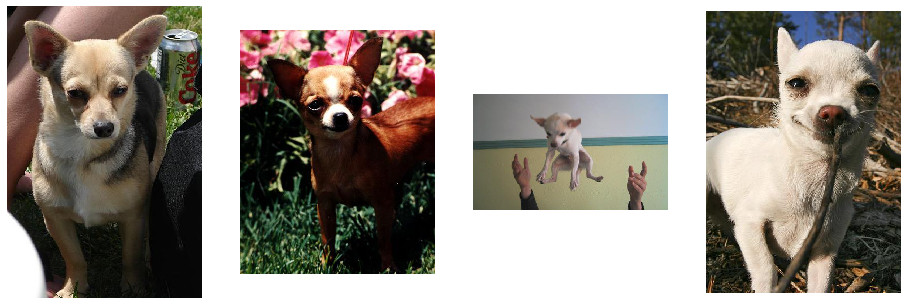

In [6]:
# Viewing a sample breed images
print(breed_list[0])
show_dir_images(breed_list[0], 4)

n02086910-papillon


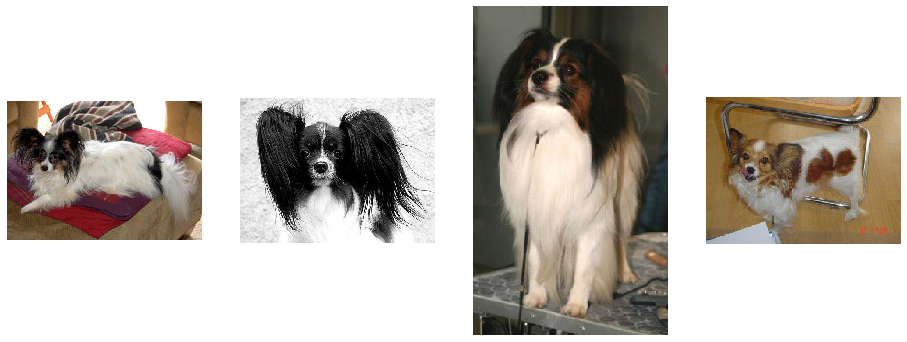

In [7]:
# Viewing another breed
print(breed_list[6])
show_dir_images(breed_list[6], 4)

# Scrubbing Data - Splitting, Normalizing, Resizing and Reshaping Datasets

Next, we will use ImageDataGenerator from Keras to gather the image data from our directory folder and split it into train and test datasets. We will use 80% of the data for training and 20% of the data for testing.

In addition, we will normalize the RGB values of the images by diving with 255 and resize the images to 227 x 227. We are using 227 x 277 for compatibility with some of the neural networks that we will create.

ImageDataGenerator will also perform one-hot-encoding for our labels.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(path, target_size=(227, 227), class_mode='categorical', 
                                                    batch_size=4537, subset='training')
test_generator = train_datagen.flow_from_directory(path, target_size=(227, 227), class_mode='categorical', 
                                                   batch_size=4537, subset='validation')


Found 3640 images belonging to 25 classes.
Found 897 images belonging to 25 classes.


In [9]:
# Assign training images and labels
train_images, train_labels = next(train_generator)

# Assign testing images and labels
test_images, test_labels = next(test_generator)

We will then split the training dataset into training and validation datasets so that we can calculate the validation metrics for our models. We will use Scikit-Learn's train_test_split function to divide the dataset into 75% training and 25% validation datasets.

In [10]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, 
                                                                      random_state=42)

Let's check if our images are correctly rescaled and resized.

In [11]:
# Checking if image data is normalized
print(train_images[0])

# Checking if image data is resized
len(train_images[0])

[[[0.8352942  0.5686275  0.6666667 ]
  [0.7411765  0.48627454 0.6039216 ]
  [0.6627451  0.4666667  0.6039216 ]
  ...
  [0.5764706  0.4156863  0.30588236]
  [0.57254905 0.41176474 0.3019608 ]
  [0.5686275  0.40784317 0.29803923]]

 [[0.82745105 0.57254905 0.65882355]
  [0.8078432  0.5568628  0.65882355]
  [0.6627451  0.4431373  0.5568628 ]
  ...
  [0.5137255  0.3921569  0.27058825]
  [0.5254902  0.4039216  0.28235295]
  [0.5411765  0.41960788 0.29803923]]

 [[0.8235295  0.5686275  0.654902  ]
  [0.72156864 0.47058827 0.5647059 ]
  [0.7686275  0.5176471  0.61960787]
  ...
  [0.48627454 0.38431376 0.25490198]
  [0.5019608  0.40000004 0.27058825]
  [0.49803925 0.39607847 0.26666668]]

 ...

 [[0.454902   0.49803925 0.4431373 ]
  [0.38823533 0.41960788 0.36078432]
  [0.3803922  0.41176474 0.3529412 ]
  ...
  [0.29803923 0.4666667  0.6       ]
  [0.32941177 0.49803925 0.63529414]
  [0.3372549  0.5058824  0.6431373 ]]

 [[0.49803925 0.5294118  0.47058827]
  [0.4156863  0.4431373  0.3803922 ]


227

It looks like all the RGB value of our sample image is between 0 and 1. Therefore, we can confirm that it has been rescaled correctly. 

The length of sample image data is 227. Therefore, we can confirm that it has been resized correctly.

Next, we will check if our lables has been one-hot-encoded correctly.

In [12]:
# Checking if the label data has been one-hot-encoded
train_labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

It looks like the labels are also in good order.

Next, we will check the shape of each dataset.

In [13]:
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (2730, 227, 227, 3)
train_labels shape: (2730, 25)
test_images shape: (897, 227, 227, 3)
test_labels shape: (897, 25)
val_images shape: (910, 227, 227, 3)
val_labels shape: (910, 25)


Our image datasets have 4 dimensions which is not compatiable with the neural networks. We will reshape them into 2 dimensions.

In [14]:
# Reshaping the image datasets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

# Re-checking the new shapes
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_img.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (2730, 154587)
train_labels shape: (2730, 25)
test_images shape: (897, 154587)
test_labels shape: (897, 25)
val_images shape: (910, 154587)
val_labels shape: (910, 25)


# Modeling the Data - Base Neural Network

Now that we have our required datasets, we can create a base neural network to test the performance.

In this base model, we will use only 3 layers -

- Input layer
- Dense hidden layer with activation = 'tanh'
- Dense output layer with activation = 'softmax'. We are using 'softmax' because we are building a multi-classifier model.

In [15]:
# Adding layers to the model
np.random.seed(123)
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(154587,)))
model_1.add(Dense(25, activation='softmax'))

In [16]:
# Compling the model
model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Checking the model's summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                9893632   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 9,895,257
Trainable params: 9,895,257
Non-trainable params: 0
_________________________________________________________________


In [17]:
results_1 = model_1.fit(train_img, train_labels, epochs=25, batch_size=64, validation_data=(val_img, val_labels))

Epoch 1/25
43/43 [==============================] - 2s 42ms/step - loss: 3.6585 - accuracy: 0.0502 - val_loss: 3.3973 - val_accuracy: 0.0604
Epoch 2/25
43/43 [==============================] - 2s 39ms/step - loss: 3.2926 - accuracy: 0.0498 - val_loss: 3.2653 - val_accuracy: 0.0604
Epoch 3/25
43/43 [==============================] - 2s 39ms/step - loss: 3.2252 - accuracy: 0.0542 - val_loss: 3.2306 - val_accuracy: 0.0615
Epoch 4/25
43/43 [==============================] - 2s 40ms/step - loss: 3.2113 - accuracy: 0.0495 - val_loss: 3.2246 - val_accuracy: 0.0462
Epoch 5/25
43/43 [==============================] - 2s 40ms/step - loss: 3.2090 - accuracy: 0.0590 - val_loss: 3.2227 - val_accuracy: 0.0473
Epoch 6/25
43/43 [==============================] - 2s 41ms/step - loss: 3.2110 - accuracy: 0.0451 - val_loss: 3.2211 - val_accuracy: 0.0615
Epoch 7/25
43/43 [==============================] - 2s 40ms/step - loss: 3.2128 - accuracy: 0.0531 - val_loss: 3.2204 - val_accuracy: 0.0659
Epoch 8/25
43

Next, we will create a function to visualize and compare the accuracy and loss scores between the training and validation datasets.

In [18]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'train_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'train_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

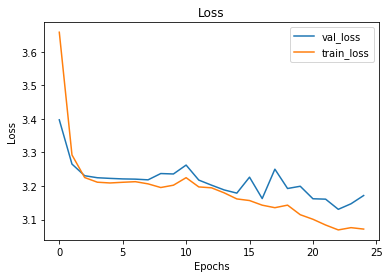

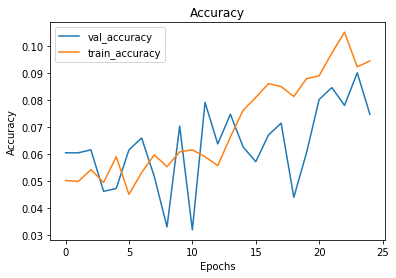

In [19]:
# Creating graphs to compare loss and accuracy scores
visualize_training_results(results_1)

The graphs indicate that the loss scores for validation and training dataset decreases continuously and converage around epoch 3. 

However, after the epoch 13, the accuracy score of the validation dataset became lower than the training's accuracy score. This shows that my model have overfitting problem.

Next, we will evaluate our model by using training and testing datasets.

In [20]:
# Checking model's performance with training data
results_train = model_1.evaluate(train_img, train_labels)

86/86 [==============================] - 1s 9ms/step - loss: 3.0802 - accuracy: 0.1026


In [21]:
# Checking model's performance with testing data
results_test = model_1.evaluate(test_img, test_labels)

29/29 [==============================] - 0s 8ms/step - loss: 3.1786 - accuracy: 0.0780


As expected, the accuracy scores are quite low. Let's see if we can improve it by preprocessing our image data.

# Scrubbing Data - Histogram Equalizating Image Data

The first technique that we will us to preprocess our data is histogram equalization. This technique will enhance the contrast in our images by using the image's histogram. The color space that we will use for this technique is YUV (Y – luminance (brightness), U and V – chrominance (color)).

To perform histogram equalization on all the images, I will write a function that also include resizing of images to 227x227.

In [22]:
def load_images_and_labels(breeds):
    
    # Creating empty lists to images and labels
    img_lst=[]
    labels=[]
    
    
    for index, breed in enumerate(breed_list):
        for image_name in os.listdir(path+"/"+breed):
            
            # Reading images from the directory
            img = cv2.imread(path+"/"+breed+"/"+image_name)
            
            # Converting images to YUV color space
            img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
            
            # Histogram Equalizing the YUV images
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
            
            # Converting back to RGB color space
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB)
            
            img_array = Image.fromarray(equ, 'RGB')
            
            #resizing images to 227x227 for model compatibility
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

In [23]:
# Using the function to agument the images
images, labels = load_images_and_labels(breed_list)

Now, let's check the resulting images and labels.

In [24]:
# Checking 1 sample image
images[0][0]

array([[ 31,  29,  34],
       [ 25,  24,  29],
       [ 14,  15,  19],
       [ 11,  14,  15],
       [ 19,  23,  24],
       [ 25,  30,  29],
       [ 19,  23,  21],
       [ 36,  38,  36],
       [ 30,  30,  28],
       [ 40,  38,  36],
       [ 36,  28,  27],
       [ 73,  58,  58],
       [128, 112, 111],
       [135, 119, 118],
       [132, 116, 115],
       [134, 118, 117],
       [130, 114, 113],
       [128, 112, 111],
       [126, 110, 109],
       [122, 106, 105],
       [119, 103, 102],
       [117, 102,  98],
       [112,  97,  92],
       [109,  94,  88],
       [105,  90,  84],
       [102,  87,  81],
       [101,  86,  80],
       [100,  85,  79],
       [100,  85,  79],
       [ 98,  83,  77],
       [ 95,  80,  74],
       [ 93,  78,  72],
       [ 91,  76,  70],
       [ 90,  76,  67],
       [ 89,  75,  66],
       [ 89,  75,  66],
       [ 87,  73,  65],
       [ 87,  72,  66],
       [ 86,  71,  67],
       [ 82,  67,  63],
       [ 83,  68,  64],
       [ 87,  71

In [25]:
# Checking 1 sample label
labels[0]

0

As we can see, the images need to normalized and the labels need to one-hot-encoded. 

In [26]:
# Converting the lists into arrays
images = np.array(images)
labels = np.array(labels)

# Normalizing the images
images = images/255

# One-hot-encoding the labels
labels = np_utils.to_categorical(labels, num_classes=25)

Let's check if the images have been normalized and the labels have been one-hot-encoded.

In [27]:
# Checking 1 sample image
images[0][0]

array([[0.12156863, 0.11372549, 0.13333333],
       [0.09803922, 0.09411765, 0.11372549],
       [0.05490196, 0.05882353, 0.0745098 ],
       [0.04313725, 0.05490196, 0.05882353],
       [0.0745098 , 0.09019608, 0.09411765],
       [0.09803922, 0.11764706, 0.11372549],
       [0.0745098 , 0.09019608, 0.08235294],
       [0.14117647, 0.14901961, 0.14117647],
       [0.11764706, 0.11764706, 0.10980392],
       [0.15686275, 0.14901961, 0.14117647],
       [0.14117647, 0.10980392, 0.10588235],
       [0.28627451, 0.22745098, 0.22745098],
       [0.50196078, 0.43921569, 0.43529412],
       [0.52941176, 0.46666667, 0.4627451 ],
       [0.51764706, 0.45490196, 0.45098039],
       [0.5254902 , 0.4627451 , 0.45882353],
       [0.50980392, 0.44705882, 0.44313725],
       [0.50196078, 0.43921569, 0.43529412],
       [0.49411765, 0.43137255, 0.42745098],
       [0.47843137, 0.41568627, 0.41176471],
       [0.46666667, 0.40392157, 0.4       ],
       [0.45882353, 0.4       , 0.38431373],
       [0.

In [28]:
# Checking 1 sample label
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Next, we will use train_test_split to divide the images and labels into training, testing and validation datasets as the percentages below - 

- Training - 70%
- Testing - 20%
- Validation - 10%

In [29]:
# Splitting the original dataset into training and testing datasets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, 
                                                                        random_state=42)

In [30]:
# Splitting the original dataset into training and validation datasets
# test_size is 0.125 to get 10% of the original dataset
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.125, 
                                                                        random_state=42)

Let's look at the shapes of each dataset -

In [31]:
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (3175, 227, 227, 3)
train_labels shape: (3175, 25)
test_images shape: (908, 227, 227, 3)
test_labels shape: (908, 25)
val_images shape: (454, 227, 227, 3)
val_labels shape: (454, 25)


As we can see, the image datasets have 4 dimensions. We will reshape it so that we can use it again for our base model.

In [32]:
# Reshaping the image datasets
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

# Re-checking the new shapes
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_img.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (3175, 154587)
train_labels shape: (3175, 25)
test_images shape: (908, 154587)
test_labels shape: (908, 25)
val_images shape: (454, 154587)
val_labels shape: (454, 25)


# Modeling the Data - Data with Histogram Equalization 

Now that we have the histogram equalized images, we will them in our base model again.

In [33]:
np.random.seed(123)
model_2 = Sequential()
model_2.add(Dense(64, activation='tanh', input_shape=(154587,)))
model_2.add(Dense(25, activation='softmax'))

In [34]:
# Compling the model
model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Checking the model's summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                9893632   
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1625      
Total params: 9,895,257
Trainable params: 9,895,257
Non-trainable params: 0
_________________________________________________________________


In [35]:
results_2 = model_2.fit(train_img, train_labels, epochs=25, batch_size=64, validation_data=(val_img, val_labels))

Epoch 1/25
50/50 [==============================] - 3s 58ms/step - loss: 3.6337 - accuracy: 0.0450 - val_loss: 3.4129 - val_accuracy: 0.0396
Epoch 2/25
50/50 [==============================] - 2s 39ms/step - loss: 3.3680 - accuracy: 0.0488 - val_loss: 3.3013 - val_accuracy: 0.0485
Epoch 3/25
50/50 [==============================] - 2s 38ms/step - loss: 3.2815 - accuracy: 0.0507 - val_loss: 3.2435 - val_accuracy: 0.0396
Epoch 4/25
50/50 [==============================] - 2s 39ms/step - loss: 3.2295 - accuracy: 0.0523 - val_loss: 3.2173 - val_accuracy: 0.0441
Epoch 5/25
50/50 [==============================] - 2s 38ms/step - loss: 3.2140 - accuracy: 0.0507 - val_loss: 3.2096 - val_accuracy: 0.0441
Epoch 6/25
50/50 [==============================] - 2s 38ms/step - loss: 3.2089 - accuracy: 0.0567 - val_loss: 3.2192 - val_accuracy: 0.0441
Epoch 7/25
50/50 [==============================] - 2s 38ms/step - loss: 3.2106 - accuracy: 0.0580 - val_loss: 3.2140 - val_accuracy: 0.0683
Epoch 8/25
50

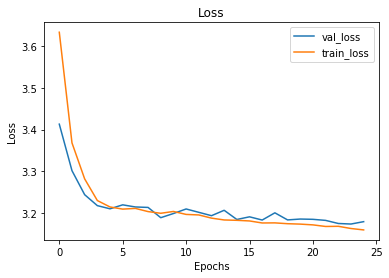

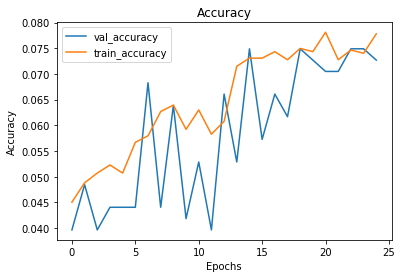

In [36]:
visualize_training_results(results_2)

Similar to the previous model, the loss scores of training and validation sets continue to decrease and converge. The accuracy scores of both datasets also continue to increase but after epoch 15, the validation's accuracy score becomes lower than the training's accuracy. This indicates that an overfitting problem.

Next, we will evaluate our model 2 with training and testing datasets.

In [37]:
# Checking model's performance with training data
results_train = model_2.evaluate(train_img, train_labels)

100/100 [==============================] - 1s 10ms/step - loss: 3.1483 - accuracy: 0.0831 0s - loss: 3.149


In [38]:
# Checking model's performance with testing data
results_test = model_2.evaluate(test_img, test_labels)

29/29 [==============================] - 0s 9ms/step - loss: 3.1725 - accuracy: 0.0804


The loss scores for both dataset increased. The accuracy score of the training dataset decreased but the testing dataset increased. This shows that our model is less overfitted.

Next, we will further augment our images and begin using a convolutional neural network to see if we can improve the scores.

# Scrubbing Data - Augmenting Image Data

For the next model, we will continue to augment the image dataset. The augmentations that we will perform are - 

- Rotate our image in the range of 30 degrees
- Flip horizontally
- Fill the points outside of the boundary with the 'nearest' mode.


In [39]:
# Setting up the Augmentation
datagen = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

# fit parameters from train_images
datagen.fit(train_images, augment=True)

# Modeling the Data - Data with Augmented Image Data

In addition to image augmenting, we will use a convolutional neural network which usually has better performance for image classications. We will also add padding to the Conv2D layers to ensure that output has the same height/width dimension as the input. In addition to Conv2D layers, we will add relu activation, maxpooling and dropout to the hidden layers. 

In [40]:
model_3 = Sequential()
# layer 1
model_3.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(227, 227, 3)))
model_3.add(BatchNormalization(axis=3, scale=False))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model_3.add(Dropout(0.2))
# layer 2
model_3.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model_3.add(BatchNormalization(axis=3, scale=False))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model_3.add(Dropout(0.2))
# layer 3
model_3.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model_3.add(BatchNormalization(axis=3, scale=False))
model_3.add(Activation("relu"))
model_3.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model_3.add(Dropout(0.2))
# layer 4
model_3.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model_3.add(BatchNormalization(axis=3, scale=False))
model_3.add(Activation("relu"))
model_3.add(Flatten())
model_3.add(Dropout(0.2))
# fully connected layers
model_3.add(Dense(512, activation='relu'))
model_3.add(Dense(25, activation='softmax'))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 227, 227, 16)      48        
_________________________________________________________________
activation (Activation)      (None, 227, 227, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 32)       

Next, we will compile the model and also set the learning rate as 0.0015 by calling Keras' set_value () function.

In [41]:
# Compling the model 
model_3.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# Setting the learning rate as 0.0015
K.set_value(model_3.optimizer.learning_rate, 0.0015)

In [42]:
results_3 =model_3.fit(datagen.flow(train_images, train_labels, batch_size=32), epochs=25, validation_data=(val_images, val_labels),
                       steps_per_epoch=len(train_images) / 32)

Epoch 1/25
100/99 [==============================] - 62s 617ms/step - loss: 3.4337 - accuracy: 0.0447 - val_loss: 3.2223 - val_accuracy: 0.0485
Epoch 2/25
100/99 [==============================] - 61s 611ms/step - loss: 3.3597 - accuracy: 0.0557 - val_loss: 3.2544 - val_accuracy: 0.0485
Epoch 3/25
100/99 [==============================] - 62s 616ms/step - loss: 3.3090 - accuracy: 0.0583 - val_loss: 3.2757 - val_accuracy: 0.0463
Epoch 4/25
100/99 [==============================] - 61s 614ms/step - loss: 3.2888 - accuracy: 0.0636 - val_loss: 3.2593 - val_accuracy: 0.0507
Epoch 5/25
100/99 [==============================] - 61s 610ms/step - loss: 3.2686 - accuracy: 0.0529 - val_loss: 3.2353 - val_accuracy: 0.0595
Epoch 6/25
100/99 [==============================] - 61s 612ms/step - loss: 3.2364 - accuracy: 0.0706 - val_loss: 3.2188 - val_accuracy: 0.0485
Epoch 7/25
100/99 [==============================] - 61s 614ms/step - loss: 3.2031 - accuracy: 0.0762 - val_loss: 3.1911 - val_accuracy:

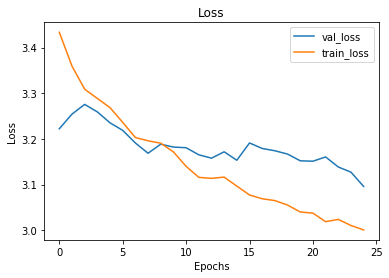

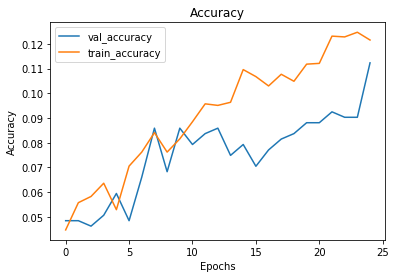

In [43]:
visualize_training_results(results_3)

This model clearly shows the overfitting problem because the loss score of validation dataset becomes higher than training's score after epoch 8. The training's accuracy score also becomes higer than validation's score around that epoch.

Now, let's evaluate this model with training and testing datasets.

In [44]:
# Checking model's performance with training data
results_train = model_3.evaluate(train_images, train_labels)

100/100 [==============================] - 7s 67ms/step - loss: 3.0765 - accuracy: 0.1083


In [45]:
# Checking model's performance with testing data
results_test = model_3.evaluate(test_images, test_labels)

29/29 [==============================] - 2s 64ms/step - loss: 3.0751 - accuracy: 0.1123


Comparing to the previous model, this model has lower loss scores and higher accuracy scores. The difference between the two accuracy scores remain approximately the same. Therefore, the overfitting problem is not gettting worse.

Next, we will continue to use our agumented image data and apply it to AlexNet convolutional network model.

In [46]:
plot_model(model_3, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Modeling the Data - AlexNet Model

AlexNet is a convolutional neural network designed by Alex Krizhevsky. It has 8 layers where the first 5 layers are convolutional layers with max-pooling layers added to some of them. These five layers are followed by 3 fully connected layers. It also mainly use Relu for the activation function except for the output layer which uses softmax.

Let's create this network - 

In [47]:
model_4 =Sequential()

#1 conv layer
model_4.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model_4.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model_4.add(BatchNormalization())

#2 conv layer
model_4.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model_4.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model_4.add(BatchNormalization())

#3 conv layer
model_4.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model_4.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model_4.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model_4.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model_4.add(BatchNormalization())

model_4.add(Flatten())

#1 dense layer
model_4.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model_4.add(Dropout(0.2))

model_4.add(BatchNormalization())

#2 dense layer
model_4.add(Dense(4096,activation="relu"))

model_4.add(Dropout(0.2))

model_4.add(BatchNormalization())

#3 dense layer
model_4.add(Dense(1000,activation="relu"))

model_4.add(Dropout(0.2))

model_4.add(BatchNormalization())

#output layer
model_4.add(Dense(25,activation="softmax"))

Similar to the previous model, we will set the learning rate as 0.0015 by calling Keras' set_value () function. Let's compile the model - 

In [48]:
# Compiling the model
model_4.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# Setting the learning rate as 0.0015
K.set_value(model_4.optimizer.learning_rate, 0.0015)

In [49]:
results_4 = model_4.fit(datagen.flow(train_images, train_labels, batch_size=32), epochs = 25, 
                        validation_data =(val_images, val_labels), steps_per_epoch=len(train_images) / 32)

Epoch 1/25
100/99 [==============================] - 71s 709ms/step - loss: 3.8550 - accuracy: 0.0693 - val_loss: 4.2759 - val_accuracy: 0.0529
Epoch 2/25
100/99 [==============================] - 72s 717ms/step - loss: 3.6162 - accuracy: 0.0806 - val_loss: 3.1697 - val_accuracy: 0.1123
Epoch 3/25
100/99 [==============================] - 71s 712ms/step - loss: 3.3807 - accuracy: 0.1071 - val_loss: 3.7067 - val_accuracy: 0.0793
Epoch 4/25
100/99 [==============================] - 71s 709ms/step - loss: 3.2597 - accuracy: 0.1140 - val_loss: 3.2671 - val_accuracy: 0.1145
Epoch 5/25
100/99 [==============================] - 71s 714ms/step - loss: 3.2030 - accuracy: 0.1213 - val_loss: 3.2732 - val_accuracy: 0.1189
Epoch 6/25
100/99 [==============================] - 72s 722ms/step - loss: 3.0247 - accuracy: 0.1465 - val_loss: 3.1174 - val_accuracy: 0.1278
Epoch 7/25
100/99 [==============================] - 72s 718ms/step - loss: 2.9831 - accuracy: 0.1603 - val_loss: 3.4958 - val_accuracy:

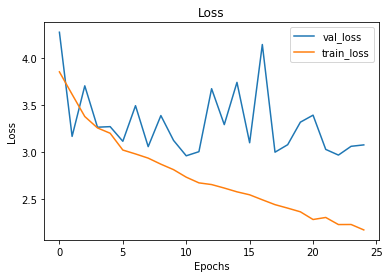

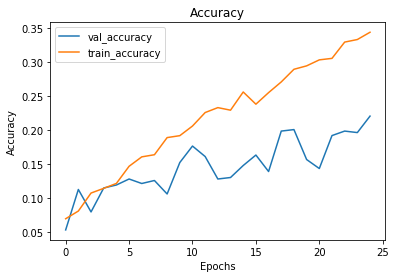

In [50]:
visualize_training_results(results_4)

In this model, the loss score of training dataset continues to decrease but the validation's score stops decreasing and becoming higher than training's score after epoch 3. Both accuracy scores continues to increase but the gap between the two scores become wider and wider. Therefore, this model surely has the overfitting problem.

Let's look at the evaluation scores -

In [51]:
# Checking model's performance with training data
results_train = model_4.evaluate(train_images, train_labels)

100/100 [==============================] - 15s 154ms/step - loss: 1.8245 - accuracy: 0.4416


In [52]:
# Checking model's performance with testing data
results_test = model_4.evaluate(test_images, test_labels)

29/29 [==============================] - 4s 148ms/step - loss: 2.8373 - accuracy: 0.2731


The loss and accuracy scores resulted from this model are the best so far. The loss scores decreased and the accuracy scores increased significantly. However, the gap between the accuracy scores of training and testing datasets is quite large due to the overfitting problem.

Next, we will explore another CNN model called VGG16.

# Modeling the Data - VGG16 Model

VGG16 is a convolutional neural network designed by K. Simonyan and A. Zisserman from the University of Oxford. It makes improvement on AlexNet by replacing large kernel-sized filters with multiple 3x3 kernel-size filters. 

In [55]:
base_model = VGG16(include_top=False, input_shape = (227, 227, 3), weights = 'imagenet')

model_5 = Sequential()
model_5.add(base_model)
model_5.add(GlobalAveragePooling2D())
model_5.add(Dropout(0.5))
model_5.add(Dense(25,activation='softmax'))
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 25)                12825     
Total params: 14,727,513
Trainable params: 14,727,513
Non-trainable params: 0
_________________________________________________________________


Similar to the previous model, we will set the learning rate as 0.0015 by calling Keras' set_value () function. Let's compile the model - 

In [56]:
# Compiling the model
model_5.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

# Setting the learning rate as 0.0015
K.set_value(model_5.optimizer.learning_rate, 0.0015)

In [57]:
results_5 = model_5.fit(datagen.flow(train_images, train_labels, batch_size=32), epochs = 25, 
                        validation_data =(val_images, val_labels), steps_per_epoch=len(train_images) / 32)

Epoch 1/25
100/99 [==============================] - 1222s 12s/step - loss: 3.3377 - accuracy: 0.0513 - val_loss: 3.2007 - val_accuracy: 0.0683
Epoch 2/25
100/99 [==============================] - 1224s 12s/step - loss: 3.2169 - accuracy: 0.0472 - val_loss: 3.1951 - val_accuracy: 0.0771
Epoch 3/25
100/99 [==============================] - 1225s 12s/step - loss: 3.2035 - accuracy: 0.0567 - val_loss: 3.1837 - val_accuracy: 0.0683
Epoch 4/25
100/99 [==============================] - 1226s 12s/step - loss: 3.1849 - accuracy: 0.0649 - val_loss: 3.1584 - val_accuracy: 0.0837
Epoch 5/25
100/99 [==============================] - 1222s 12s/step - loss: 3.1820 - accuracy: 0.0721 - val_loss: 3.1532 - val_accuracy: 0.0925
Epoch 6/25
100/99 [==============================] - 1229s 12s/step - loss: 3.1700 - accuracy: 0.0674 - val_loss: 3.1392 - val_accuracy: 0.1189
Epoch 7/25
100/99 [==============================] - 1233s 12s/step - loss: 3.1395 - accuracy: 0.0850 - val_loss: 3.0794 - val_accuracy:

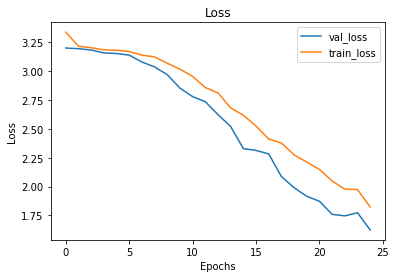

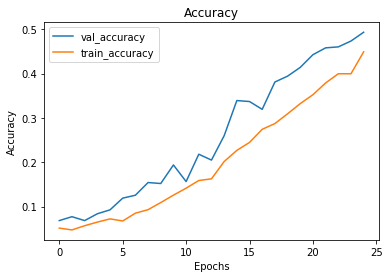

In [58]:
visualize_training_results(results_5)

The loss scores of both datasets continue to decrease and the accuracy scores continue to increase. The loss score of validation is lower than training's score and its accuracy score is hiher than training's score through out the model training. This indicates that the overfitting problem that we previously had has been resolved.

Now, let's evaluate this model with the trianing and testing datasets -

In [59]:
# Checking model's performance with training data
results_train = model_5.evaluate(train_images, train_labels)

100/100 [==============================] - 311s 3s/step - loss: 1.4053 - accuracy: 0.6035


In [60]:
# Checking model's performance with testing data
results_test = model_5.evaluate(test_images, test_labels)

29/29 [==============================] - 83s 3s/step - loss: 1.5213 - accuracy: 0.5518


Compare to the AlexNet Model, the VGG16 model has the lower loss scores and higher accuracy scores. Although the accuracy scores are still low, it is much better than the accuracy that you will get from randomly picking a dog breed out of 25 breeds. Thus, we will pick VGG16 as our final model.

# Predicting Dog Breeds

Now that we have our final model, we can use it to predict breeds by feeding dog images into its CNN. In these predictions, we will try to predict 5 breeds for each image with their respective probability percentages. This is a good way to capture mixed breeds.

Also, we will only use the images of dog breeds that we used to train our model (i.e. 25 breeds). 

To begin, we will first create a dictionary of dog breeds and indexes. This dictionary will be used to correctly print out the breed.

In [133]:
# Creating an empty dictionary
label_maps_rev = {}

# Using the for loop to insert indexes and breed names in the dictionary
for i, v in enumerate(breed_list):
    label_maps_rev.update({i : v})

Next, we will write a function that can take the image's url, save it in our directory, show the image and then use the image to predict the 5 breeds with highest probabilities. 

In [140]:
def download_and_predict(url, filename):
    
    # download the image from the url and save
    os.system("curl -s {} -o {}".format(url, filename))
    
    # open the image
    img = Image.open(filename)
    
    # save the image
    img.save(filename)
    
    # convert it to RGB
    img = img.convert('RGB')
    
    # show image
    plt.imshow(img)
    plt.axis('off')
    
    # resize the image for VGG16 model
    img = img.resize((227, 227))
        
    # calculate probabilities of breeds
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    
    # use argsort() to sort the indexes of the breeds
    # print the breed names and percentages of top 5 breeds with highest probabilities 
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split('-',1)[1])

Let's try out our model. We will use an image of a italian greyhound.

46.47% 	 Italian_greyhound
28.67% 	 papillon
21.59% 	 basset
2.29% 	 Irish_wolfhound
0.73% 	 toy_terrier


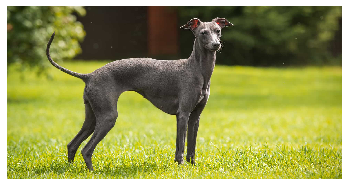

In [141]:
download_and_predict("http://www.breedadvisor.co.uk/wp-content/uploads/2020/02/ITALIAN-GREYHOUNDS-SIZE.jpg", "test_1.jpg")

Our model predicts that the dog in the image is 46.47% Italian Greyhound. It is a decent prediction.

Next, we will ue a picture of a Shih Tzu.

76.03% 	 Rhodesian_ridgeback
14.31% 	 Irish_wolfhound
6.53% 	 redbone
1.61% 	 Shih-Tzu
0.88% 	 beagle


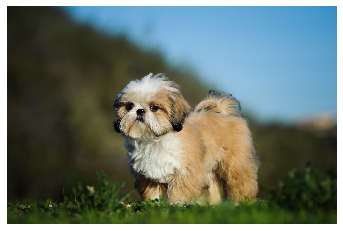

In [147]:
download_and_predict("https://www.pets4homes.co.uk/images/articles/1532/large/five-useful-things-to-know-about-the-shih-tzu-puppy-5ce28dbbd4f12.jpg", 
                     "test_2.jpg")

This prediction is quite poor since it only shows 1.61% of Shih Tzu.

Next, we will try an image of a Rhodesian Ridgeback.

62.09% 	 Irish_wolfhound
37.16% 	 Rhodesian_ridgeback
0.74% 	 toy_terrier
0.01% 	 Italian_greyhound
0.00% 	 papillon


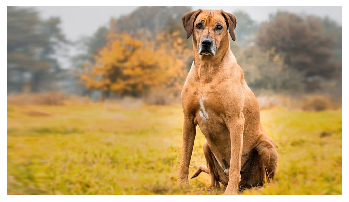

In [151]:
download_and_predict("https://www.rover.com/blog/wp-content/uploads/2019/11/top-names-rhodesian-ridgeback-960x540.jpg",
                     "test_3.jpg")

This is not a bad prediction since it shows 37.16% of Rhodesian Ridgeback.

# Areas for Improvements

The areas that I can work on in the future to improve the accuracy score of my model are -

- Use the entire dataset of 120 breeds. More image data will enhance the predictory power of my model.
<br>
- Preprocess the image data further. I could crop the images in order to remove the noises in the image data and only focus on the dogs.
<br>
- Add more layers to the VGG16 model in order to see if the new layers can increase the accuracy score.